In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Dataset

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"], index_col="Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<AxesSubplot: xlabel='Date'>

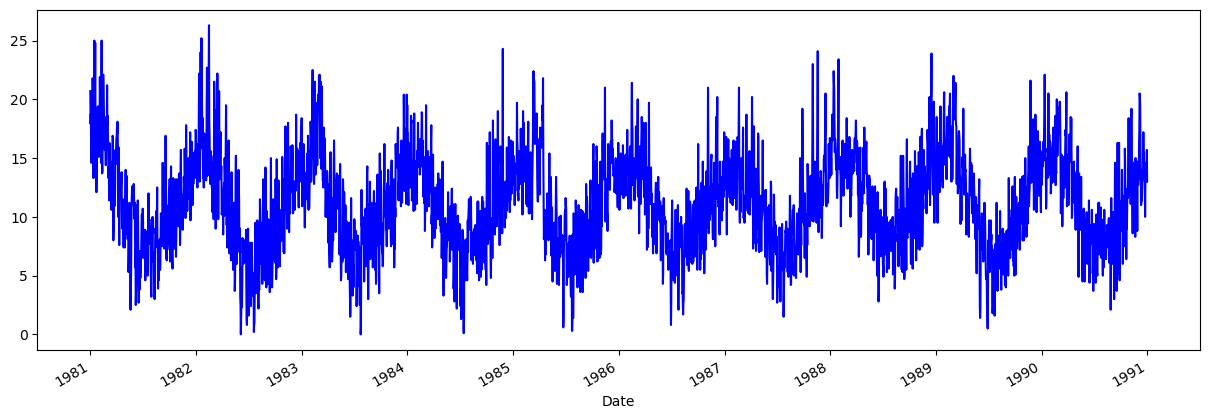

In [4]:
df.Temp.plot(figsize=(15, 5), color="b")

# Dataset Splitting

In [5]:
ts_train, ts_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [6]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [7]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)  

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [8]:
from jcopdl.layers import linear_block

In [9]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout) :
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [10]:
config = set_config({
    "input_size" : train_set.n_feature, 
    "seq_len" :  train_set.n_seq,    
    "output_size" : 1,
    "hidden_size" : 64,
    "num_layers" : 3,
    "dropout" : 0,
})

# Training Preparation -> MCOC

In [11]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

# Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 130.3046 | Test_cost  = 123.3846 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 105.5154 | Test_cost  = 96.9769 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 82.2442 | Test_cost  = 77.9098 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 66.9188 | Test_cost  = 65.6023 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 56.7256 | Test_cost  = 56.7554 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 49.1596 | Test_cost  = 49.7414 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 43.0491 | Test_cost  = 43.8985 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 37.9620 | Test_cost  = 38.9880 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 33.7204 | Test_cost  = 34.8757 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 30.2059 | Test_cost  = 31.4539 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 27.3178 | Test_cost  = 28.6264 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 24.9644 | Test_cost  = 26.3052 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 23.0625 | Test_cost  = 24.4113 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 21.5376 | Test_cost  = 22.8748 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 20.3246 | Test_cost  = 21.6351 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 19.3673 | Test_cost  = 20.6400 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 18.6179 | Test_cost  = 19.8452 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 18.0362 | Test_cost  = 19.2135 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 17.5883 | Test_cost  = 18.7135 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 17.2465 | Test_cost  = 18.3193 | 


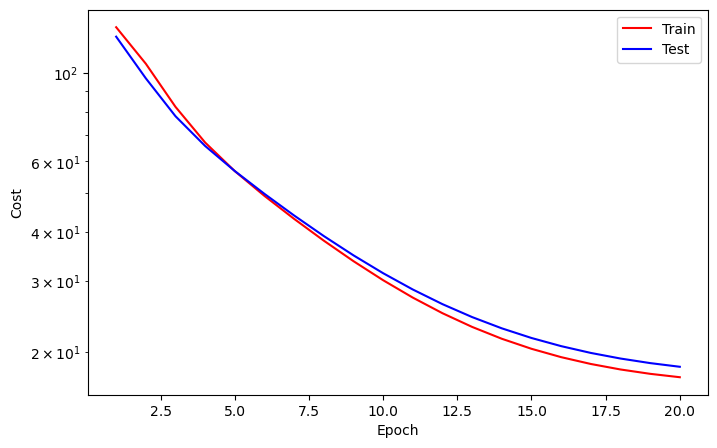

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 16.9876 | Test_cost  = 18.0095 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 16.7932 | Test_cost  = 17.7666 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 16.6483 | Test_cost  = 17.5765 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 16.5409 | Test_cost  = 17.4277 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 16.4617 | Test_cost  = 17.3112 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 16.4035 | Test_cost  = 17.2200 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 16.3608 | Test_cost  = 17.1483 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 16.3293 | Test_cost  = 17.0919 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 16.3060 | Test_cost  = 17.0473 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 16.2885 | Test_cost  = 17.0119 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 16.2752 | Test_cost  = 16.9836 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 16.2647 | Test_cost  = 16.9610 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 16.2564 | Test_cost  = 16.9428 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 16.2495 | Test_cost  = 16.9280 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 16.2436 | Test_cost  = 16.9159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 16.2384 | Test_cost  = 16.9060 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 16.2337 | Test_cost  = 16.8978 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 16.2293 | Test_cost  = 16.8909 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 16.2252 | Test_cost  = 16.8850 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 16.2212 | Test_cost  = 16.8799 | 


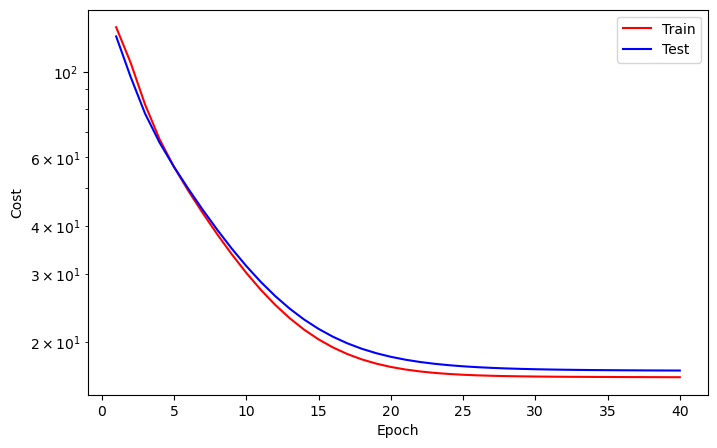

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 16.2174 | Test_cost  = 16.8755 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 16.2136 | Test_cost  = 16.8716 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 16.2098 | Test_cost  = 16.8680 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 16.2061 | Test_cost  = 16.8648 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 16.2024 | Test_cost  = 16.8618 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 16.1986 | Test_cost  = 16.8589 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 16.1948 | Test_cost  = 16.8562 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 16.1910 | Test_cost  = 16.8536 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 16.1871 | Test_cost  = 16.8510 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 16.1831 | Test_cost  = 16.8485 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 16.1791 | Test_cost  = 16.8460 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 16.1749 | Test_cost  = 16.8436 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 16.1707 | Test_cost  = 16.8411 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 16.1663 | Test_cost  = 16.8387 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 16.1618 | Test_cost  = 16.8363 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 16.1571 | Test_cost  = 16.8339 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 16.1523 | Test_cost  = 16.8315 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 16.1473 | Test_cost  = 16.8291 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 16.1421 | Test_cost  = 16.8267 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 16.1366 | Test_cost  = 16.8242 | 


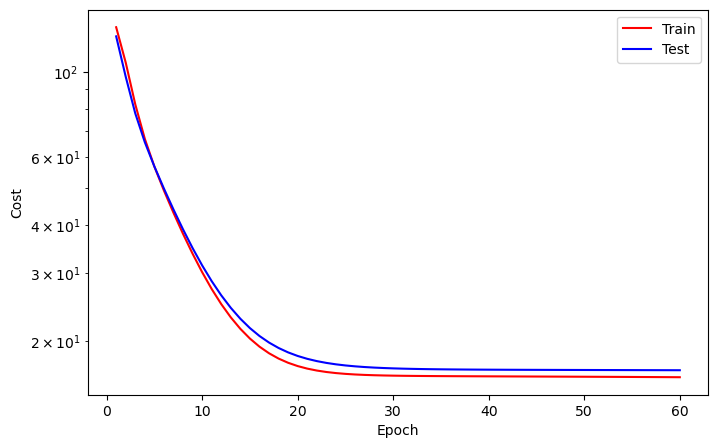

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 16.1309 | Test_cost  = 16.8218 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 16.1247 | Test_cost  = 16.8192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 16.1182 | Test_cost  = 16.8166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 16.1110 | Test_cost  = 16.8139 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 16.1032 | Test_cost  = 16.8109 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 16.0944 | Test_cost  = 16.8078 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 16.0843 | Test_cost  = 16.8042 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 16.0721 | Test_cost  = 16.8000 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 16.0569 | Test_cost  = 16.7946 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 16.0363 | Test_cost  = 16.7867 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 16.0054 | Test_cost  = 16.7720 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 15.9497 | Test_cost  = 16.7291 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 15.7990 | Test_cost  = 16.4050 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 14.7383 | Test_cost  = 14.3609 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 13.2474 | Test_cost  = 13.5458 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 12.3669 | Test_cost  = 12.4898 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 11.5527 | Test_cost  = 11.5428 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 10.8259 | Test_cost  = 10.7865 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 10.2731 | Test_cost  = 10.1114 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 9.8067 | Test_cost  = 9.5076 | 


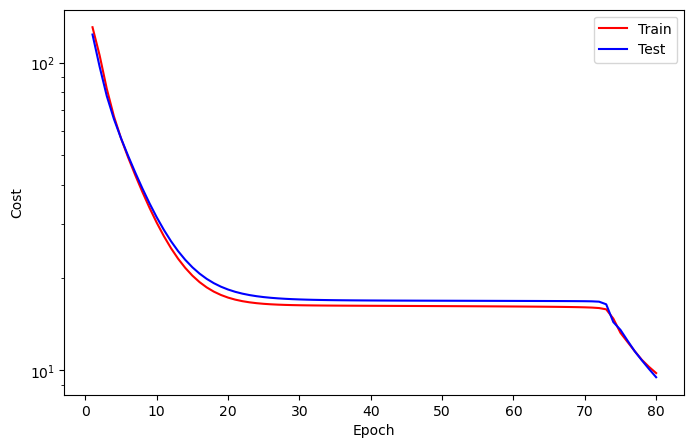

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 9.3757 | Test_cost  = 9.0212 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 9.0196 | Test_cost  = 8.6241 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 8.7358 | Test_cost  = 8.2853 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 8.4933 | Test_cost  = 7.9902 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 8.2736 | Test_cost  = 7.7380 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 8.0729 | Test_cost  = 7.5204 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 7.8991 | Test_cost  = 7.3330 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 7.7552 | Test_cost  = 7.1717 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 7.6340 | Test_cost  = 7.0300 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 7.5278 | Test_cost  = 6.9050 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 7.4335 | Test_cost  = 6.7932 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 7.3489 | Test_cost  = 6.6921 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 7.2732 | Test_cost  = 6.6007 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 7.2055 | Test_cost  = 6.5170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 7.1444 | Test_cost  = 6.4397 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 7.0885 | Test_cost  = 6.3674 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 7.0362 | Test_cost  = 6.2993 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 6.9868 | Test_cost  = 6.2355 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 6.9399 | Test_cost  = 6.1761 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 6.8958 | Test_cost  = 6.1212 | 


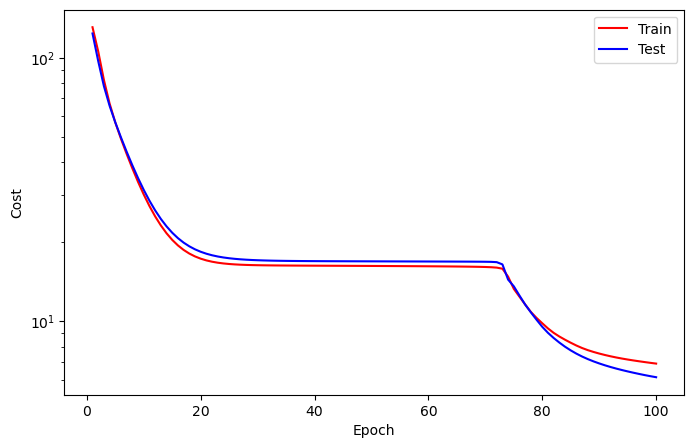

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 6.8549 | Test_cost  = 6.0704 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 6.8173 | Test_cost  = 6.0234 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 6.7827 | Test_cost  = 5.9797 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 6.7509 | Test_cost  = 5.9390 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 6.7214 | Test_cost  = 5.9008 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 6.6938 | Test_cost  = 5.8648 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 6.6677 | Test_cost  = 5.8305 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 6.6426 | Test_cost  = 5.7976 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 6.6182 | Test_cost  = 5.7660 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 6.5947 | Test_cost  = 5.7355 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 6.5720 | Test_cost  = 5.7062 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 6.5505 | Test_cost  = 5.6781 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 6.5301 | Test_cost  = 5.6513 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 6.5108 | Test_cost  = 5.6257 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 6.4925 | Test_cost  = 5.6011 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 6.4751 | Test_cost  = 5.5777 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 6.4583 | Test_cost  = 5.5553 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 6.4423 | Test_cost  = 5.5339 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 6.4269 | Test_cost  = 5.5132 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 6.4123 | Test_cost  = 5.4930 | 


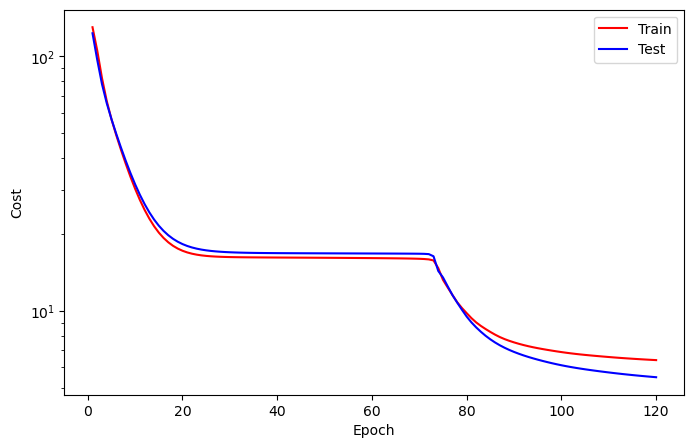

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 6.3989 | Test_cost  = 5.4735 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 6.3869 | Test_cost  = 5.4552 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 6.3760 | Test_cost  = 5.4381 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 6.3659 | Test_cost  = 5.4215 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 6.3561 | Test_cost  = 5.4054 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 6.3464 | Test_cost  = 5.3898 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 6.3367 | Test_cost  = 5.3749 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 6.3272 | Test_cost  = 5.3606 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 6.3178 | Test_cost  = 5.3470 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 6.3086 | Test_cost  = 5.3340 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 6.2995 | Test_cost  = 5.3217 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 6.2907 | Test_cost  = 5.3100 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 6.2820 | Test_cost  = 5.2989 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 6.2734 | Test_cost  = 5.2884 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 6.2651 | Test_cost  = 5.2784 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 6.2569 | Test_cost  = 5.2689 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 6.2489 | Test_cost  = 5.2597 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 6.2410 | Test_cost  = 5.2510 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 6.2334 | Test_cost  = 5.2426 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 6.2259 | Test_cost  = 5.2346 | 


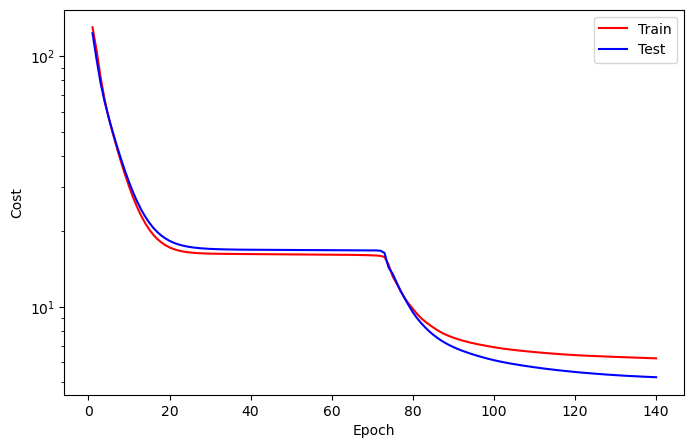

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 6.2186 | Test_cost  = 5.2268 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 6.2115 | Test_cost  = 5.2193 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 6.2048 | Test_cost  = 5.2121 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 6.1987 | Test_cost  = 5.2052 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 6.1931 | Test_cost  = 5.1986 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 6.1878 | Test_cost  = 5.1920 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 6.1821 | Test_cost  = 5.1857 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 6.1758 | Test_cost  = 5.1800 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 6.1690 | Test_cost  = 5.1748 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 6.1619 | Test_cost  = 5.1700 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 6.1548 | Test_cost  = 5.1656 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 6.1477 | Test_cost  = 5.1613 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 6.1409 | Test_cost  = 5.1571 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 6.1342 | Test_cost  = 5.1529 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 6.1278 | Test_cost  = 5.1489 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 6.1216 | Test_cost  = 5.1451 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 6.1156 | Test_cost  = 5.1413 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 6.1098 | Test_cost  = 5.1377 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 6.1041 | Test_cost  = 5.1343 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 6.0984 | Test_cost  = 5.1310 | 


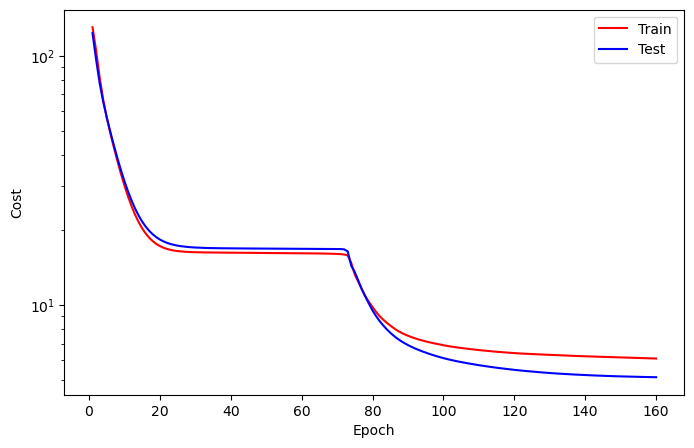

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 6.0927 | Test_cost  = 5.1279 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 6.0870 | Test_cost  = 5.1249 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 6.0812 | Test_cost  = 5.1220 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 6.0754 | Test_cost  = 5.1192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 6.0695 | Test_cost  = 5.1165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 6.0636 | Test_cost  = 5.1138 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 6.0578 | Test_cost  = 5.1113 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 6.0520 | Test_cost  = 5.1089 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 6.0465 | Test_cost  = 5.1066 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 6.0412 | Test_cost  = 5.1047 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 6.0361 | Test_cost  = 5.1030 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 6.0311 | Test_cost  = 5.1017 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 6.0262 | Test_cost  = 5.1006 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 6.0211 | Test_cost  = 5.0999 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 6.0157 | Test_cost  = 5.0993 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 6.0101 | Test_cost  = 5.0988 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 6.0043 | Test_cost  = 5.0983 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 5.9983 | Test_cost  = 5.0978 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 5.9921 | Test_cost  = 5.0971 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 5.9858 | Test_cost  = 5.0964 | 


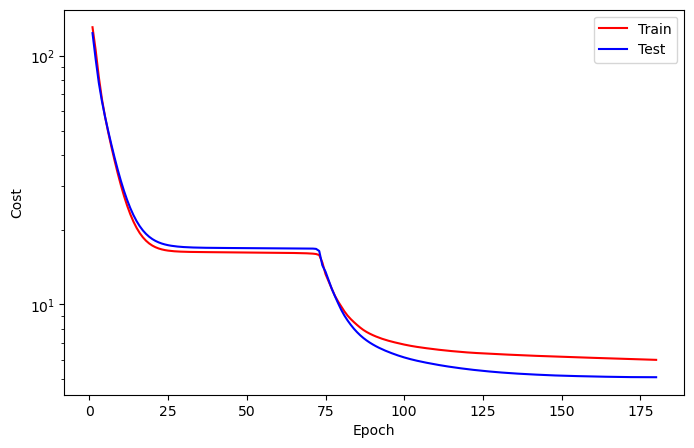

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 5.9795 | Test_cost  = 5.0956 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 5.9730 | Test_cost  = 5.0948 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 5.9665 | Test_cost  = 5.0941 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 5.9600 | Test_cost  = 5.0934 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 5.9534 | Test_cost  = 5.0927 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 5.9469 | Test_cost  = 5.0923 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 5.9403 | Test_cost  = 5.0919 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 5.9337 | Test_cost  = 5.0918 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 5.9270 | Test_cost  = 5.0918 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0918


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 5.9203 | Test_cost  = 5.0920 | 
==> EarlyStop patience =  2 | Best test_cost: 5.0918


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 5.9137 | Test_cost  = 5.0925 | 
==> EarlyStop patience =  3 | Best test_cost: 5.0918


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 5.9069 | Test_cost  = 5.0931 | 
==> EarlyStop patience =  4 | Best test_cost: 5.0918


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 5.9002 | Test_cost  = 5.0940 | 
==> EarlyStop patience =  5 | Best test_cost: 5.0918
==> Execute Early Stopping at epoch: 193 | Best test_cost: 5.0918
==> Best model is saved at model/gru


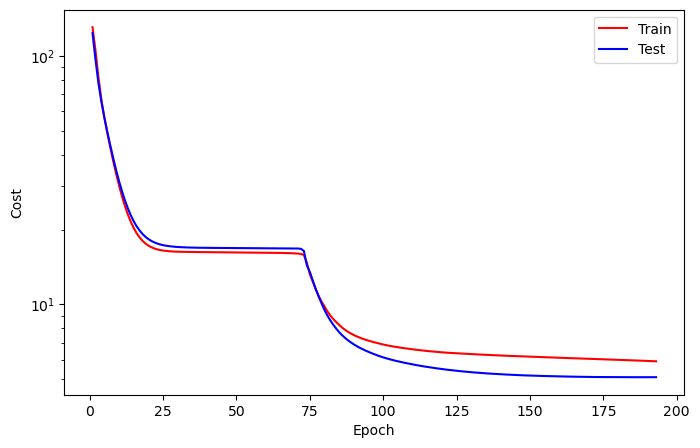

In [13]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
        
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [14]:
from luwiji.rnn import illustration

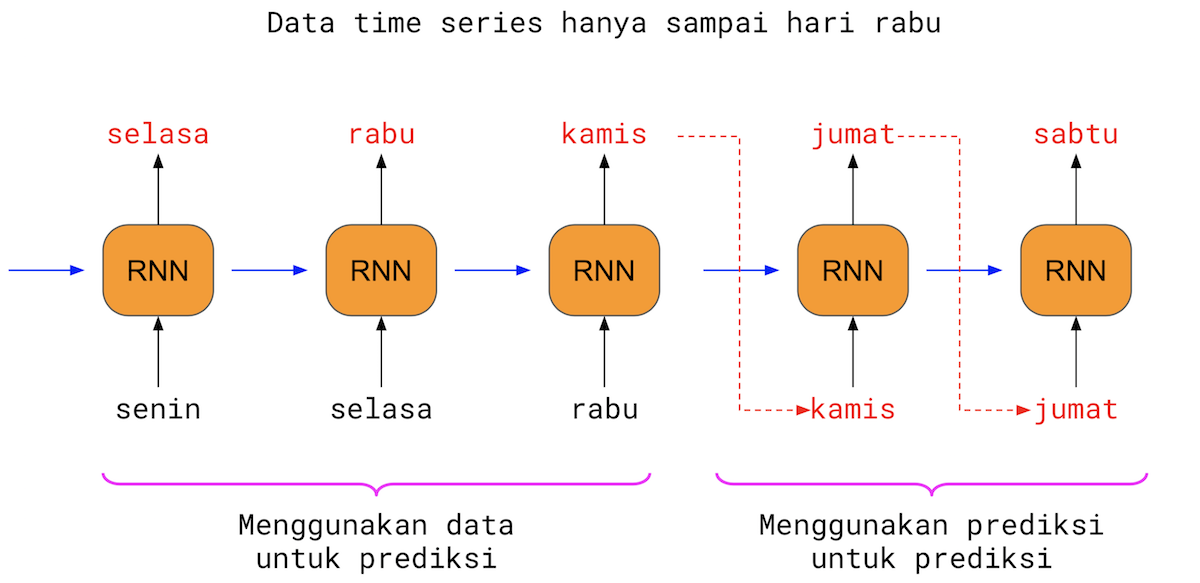

In [15]:
illustration.forecast

In [16]:
from utils import data4pred, pred4pred

In [17]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)  

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

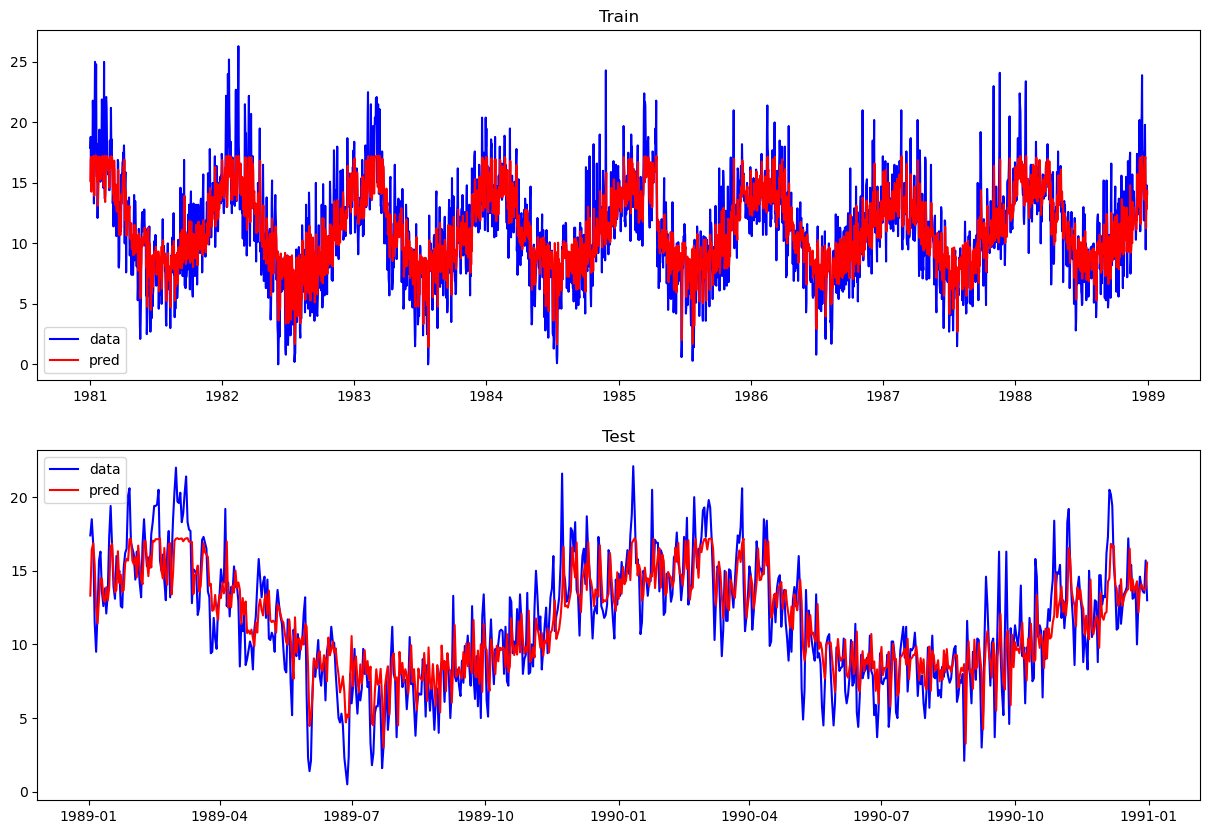

In [18]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

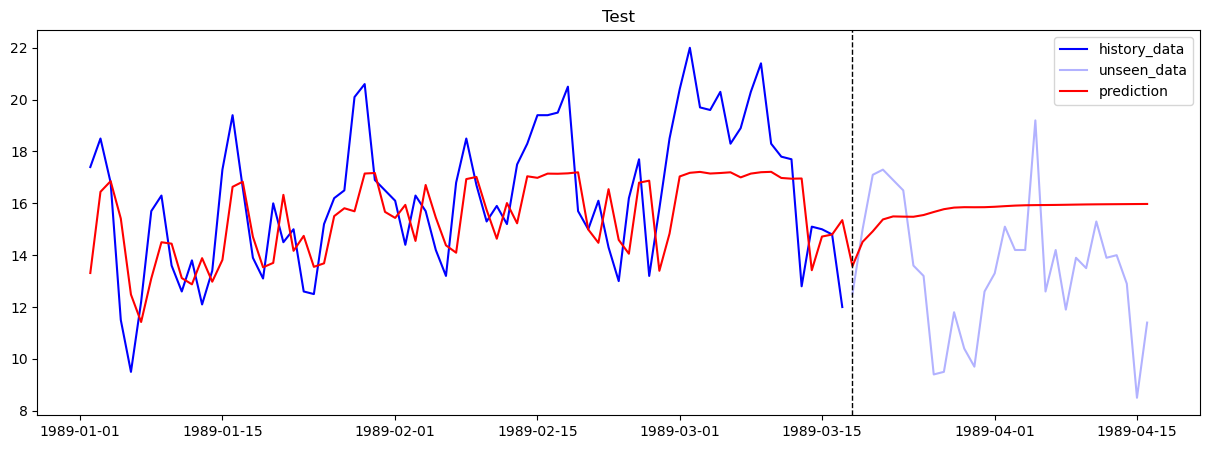

In [19]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test");